In [1]:
# Mount Drive and CHange Dir
from google.colab import drive
drive.mount('gdrive')

%cd gdrive/My Drive/Colab Notebooks/Fantasy_Football

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive
/content/gdrive/My Drive/Colab Notebooks/Fantasy_Football


In [ ]:
import pandas as pd
import numpy as np

# WR Advanced Stats (Passer Rating)
rec_adv_df = pd.read_csv('Receiving_adv.csv')
rec_adv_df = rec_adv_df[rec_adv_df['Pos'].str.lower() == 'wr']
rec_adv_df['Player'] = rec_adv_df['Player'].str.split('\\').str[0]
rec_adv_df[['Rk','Player','Tm','Age','G','GS','Rat']].sort_values(by='Rat', ascending=True)[:30]

# Running Backs

We'll be looking at RB stats from last season, analyzing rushing/receiving variance to identify low variability performers:

1. Create a Master DataFrame consisting of previous season stats and variance
2. Clustering Algorithm on **Rushing Variance** and **Receiving Variance**
3. Shortlist running backs to **DRAFT** and **AVOID** based on variability

---

*DISCLAIMER:*

*Pre-Draft Analysis only based on 2019 NFL Season performance and excludes Strength of Schedule for the upcoming season.*


## Master DataFrame

Consolidate rushing/receiving stats and weekly variance from 2019 season

In [80]:
import pandas as pd
import numpy as np

# base dataframe (rushing)
rush_df = pd.read_csv('Rushing.csv')
rush_df = rush_df[rush_df['Pos'].str.lower() == 'rb']
Att_G = rush_df['Att']/rush_df['G']
rush_df.insert(12, 'Att/G', Att_G)
rush_df['Player'] = rush_df['Player'].str.split('\\').str[0]
rush_df['FP/G'] = (rush_df['TD']*6 + rush_df['Yds']/10 - rush_df['Fmb'])/rush_df['G']
rush_df.drop('Rk', axis=1, inplace=True)
rush_df.rename(columns={'Yds':'Rush_Yds', 'TD':'Rush_TD', '1D':'Rush_1D', 'Lng':'Rush_Lng', 'Y/G':'Rush_Y/G', 'Fmb':'Rush_Fmb', 'FP/G':'Rush_FP/G'}, inplace=True)

# base dataframe (receiving)
rush_df_2 = pd.read_csv('Receiving.csv')
rush_df_2 = rush_df_2[rush_df_2['Pos'].str.lower() == 'rb']
Tgt_G = rush_df_2['Tgt']/rush_df_2['G']
rush_df_2.insert(16, 'Tgt/G', Tgt_G)
rush_df_2['Player'] = rush_df_2['Player'].str.split('\\').str[0]
rush_df_2['FP/G'] = (rush_df_2['Rec']*0.5 + rush_df_2['TD']*6 + rush_df_2['Yds']/10)/rush_df_2['G']
rush_df_2.drop('Rk', axis=1, inplace=True)
rush_df_2.rename(columns={'Yds':'Rec_Yds', 'TD':'Rec_TD', '1D':'Rec_1D', 'Lng':'Rec_Lng', 'Y/G':'Rec_Y/G', 'Fmb':'Rec_Fmb', 'FP/G':'Rec_FP/G'}, inplace=True)

# Merge two base dataframes
rush_df_base = rush_df.merge(rush_df_2.drop(['Tm', 'Age', 'Pos', 'G', 'GS'], axis=1), how='left', on=['Player'])
rush_df_base['TFP/G'] = rush_df_base['Rush_FP/G'] + rush_df_base['Rec_FP/G']

# Player list for eligible 40 running backs
player_list = rush_df_base['Player'].values.tolist()

rush_df_base.head()

,Player,Tm,Age,Pos,G,GS,Att,Rush_Yds,Rush_TD,Rush_1D,Rush_Lng,Att/G,Y/A,Rush_Y/G,Rush_Fmb,Rush_FP/G,Tgt,Rec,Ctch%,Rec_Yds,Y/R,Rec_TD,Rec_1D,Rec_Lng,Y/Tgt,Tgt/G,R/G,Rec_Y/G,Rec_Fmb,Rec_FP/G,TFP/G
0,Derrick Henry,TEN,25,RB,15,15,303,1540,16,73,74,20.200000,5.1,102.7,5,16.333333,24,18,75.0%,206,11.4,2,4,75,8.6,1.600000,1.2,13.7,5,2.773333,19.106667
1,Ezekiel Elliott,DAL,24,RB,16,16,301,1357,12,78,33,18.812500,4.5,84.8,3,12.793750,71,54,76.1%,420,7.8,2,21,27,5.9,4.437500,3.4,26.3,3,5.062500,17.856250
2,Nick Chubb,CLE,24,RB,16,16,298,1494,8,62,88,18.625000,5.0,93.4,3,12.150000,49,36,73.5%,278,7.7,0,13,32,5.7,3.062500,2.3,17.4,3,2.862500,15.012500
3,Christian McCaffrey,CAR,23,RB,16,16,287,1387,15,57,84,17.937500,4.8,86.7,1,14.231250,142,116,81.7%,1005,8.7,4,58,28,7.1,8.875000,7.3,62.8,1,11.406250,25.637500
4,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,18.533333,4.4,82.0,7,10.533333,47,37,78.7%,266,7.2,2,10,21,5.7,3.133333,2.5,17.7,7,3.806667,14.340000


In [124]:
# 2019 Season Weekly Performance dataframe
rush_wkly_df = pd.read_csv('rb_wkly.csv')
rush_wkly_df['Player'] = rush_wkly_df['Player'].str.split('\\').str[0]
rush_wkly_df['Fantasy Points'] = rush_wkly_df['Rush_TD']*6 + rush_wkly_df['Rec_TD']*6 + rush_wkly_df['Rush_Yds']/10 + rush_wkly_df['Rec_Yds']/10 + rush_wkly_df['Rec']*0.5 - rush_wkly_df['Fmb']

# Merge player games into variance/std dev stats
var_list = []
for playerName in player_list:
  player_var = rush_wkly_df[rush_wkly_df['Player']==playerName].sort_values(by='G#').reset_index(drop=True)[['Att','Rush_Yds','Y/A','Rush_TD','Tgt','Rec','Rec_Yds','Y/R','Rec_TD','Y/Tgt','Fantasy Points']].var()
  player_var['Gms'] = rush_wkly_df[rush_wkly_df['Player']==playerName]['G#'].count()
  name_df = pd.DataFrame([playerName], columns=['Player'])
  concatenate = pd.concat([name_df.iloc[0], player_var], axis=0)
  name_var = pd.DataFrame(columns=['Player','Gms','Att','Rush_Yds','Y/A','Rush_TD','Tgt','Rec','Rec_Yds','Y/R','Rec_TD','Y/Tgt','Fantasy Points'])
  add_player = name_var.append(concatenate, ignore_index=True)
  add_player.rename(columns={'Att':'Att_Var','Rush_Yds':'Rush_Yds_Var','Y/A':'Y/A_Var','Rush_TD':'Rush_TD_Var','Tgt':'Tgt_Var','Rec':'Rec_Var','Rec_Yds':'Rec_Yds_Var','Y/R':'Y/R_Var','Rec_TD':'Rec_TD_Var','Y/Tgt':'Y/Tgt_Var','Fantasy Points':'FP_Var'}, inplace=True)
  var_list.append(add_player)
variance = pd.concat(var_list)
std_dev = variance.copy()
std_dev.iloc[:, 2:] = np.sqrt(std_dev.iloc[:, 2:])
std_dev.reset_index(drop=True, inplace=True)
std_dev.head()

,Player,Gms,Att_Var,Rush_Yds_Var,Y/A_Var,Rush_TD_Var,Tgt_Var,Rec_Var,Rec_Yds_Var,Y/R_Var,Rec_TD_Var,Y/Tgt_Var,FP_Var
0,Derrick Henry,15.0,5.157519,51.771016,1.808071,0.883715,1.055597,0.941124,19.469634,19.985665,0.351866,10.218026,10.229402
1,Ezekiel Elliott,16.0,4.707706,34.072900,1.430128,0.683130,2.502499,2.187083,18.357560,3.973148,0.341565,2.943647,5.873440
2,Nick Chubb,16.0,3.480900,34.484538,1.707927,0.894427,1.913766,1.570563,15.632765,5.896473,0.000000,5.296403,8.897930
3,Christian McCaffrey,16.0,5.157115,46.963417,2.173357,0.771902,3.685557,3.605551,32.884077,1.791256,0.447214,1.716401,9.550628
4,Chris Carson,14.0,6.066029,32.965850,1.003629,0.650444,1.637473,1.650841,13.432779,4.726614,0.363137,5.172677,6.307958


In [84]:
# Merge std_dev dataframe with base dataframe
rush_master_df = rush_df_base.merge(std_dev.drop('Gms', axis=1), how='left', on=['Player'])
rush_master_df.head()

,Player,Tm,Age,Pos,G,GS,Att,Rush_Yds,Rush_TD,Rush_1D,Rush_Lng,Att/G,Y/A,Rush_Y/G,Rush_Fmb,Rush_FP/G,Tgt,Rec,Ctch%,Rec_Yds,Y/R,Rec_TD,Rec_1D,Rec_Lng,Y/Tgt,Tgt/G,R/G,Rec_Y/G,Rec_Fmb,Rec_FP/G,TFP/G,Att_Var,Rush_Yds_Var,Y/A_Var,Rush_TD_Var,Tgt_Var,Rec_Var,Rec_Yds_Var,Y/R_Var,Rec_TD_Var,Y/Tgt_Var,FP_Var
0,Derrick Henry,TEN,25,RB,15,15,303,1540,16,73,74,20.200000,5.1,102.7,5,16.333333,24,18,75.0%,206,11.4,2,4,75,8.6,1.600000,1.2,13.7,5,2.773333,19.106667,5.157519,51.771016,1.808071,0.883715,1.055597,0.941124,19.469634,19.985665,0.351866,10.218026,10.229402
1,Ezekiel Elliott,DAL,24,RB,16,16,301,1357,12,78,33,18.812500,4.5,84.8,3,12.793750,71,54,76.1%,420,7.8,2,21,27,5.9,4.437500,3.4,26.3,3,5.062500,17.856250,4.707706,34.072900,1.430128,0.683130,2.502499,2.187083,18.357560,3.973148,0.341565,2.943647,5.873440
2,Nick Chubb,CLE,24,RB,16,16,298,1494,8,62,88,18.625000,5.0,93.4,3,12.150000,49,36,73.5%,278,7.7,0,13,32,5.7,3.062500,2.3,17.4,3,2.862500,15.012500,3.480900,34.484538,1.707927,0.894427,1.913766,1.570563,15.632765,5.896473,0.000000,5.296403,8.897930
3,Christian McCaffrey,CAR,23,RB,16,16,287,1387,15,57,84,17.937500,4.8,86.7,1,14.231250,142,116,81.7%,1005,8.7,4,58,28,7.1,8.875000,7.3,62.8,1,11.406250,25.637500,5.157115,46.963417,2.173357,0.771902,3.685557,3.605551,32.884077,1.791256,0.447214,1.716401,9.550628
4,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,18.533333,4.4,82.0,7,10.533333,47,37,78.7%,266,7.2,2,10,21,5.7,3.133333,2.5,17.7,7,3.806667,14.340000,6.066029,32.965850,1.003629,0.650444,1.637473,1.650841,13.432779,4.726614,0.363137,5.172677,6.307958


## Clustering for Variability

We have selected the following 6 features (3 pairs) to form clusters on players' consistency (weekly) last season.

- **Att_Var** : Rush attempt Variance (Std.Dev)
- **Y/A_Var** : Yards per Attempt Variance (Std.Dev)`
- **Tgt_Var** : Target Variance (Std.Dev)
- **Y/Tgt_Var** : Yards per Target Variance (Std.Dev)
- **Rec_Var** : Reception Variance (Std.Dev)
- **Y/R_Var** : Yards per Reception Variance (Std.Dev)

In [283]:
# Extract aforementioned features
con_rush_df_name = rush_master_df.copy()[['Player', 'Att_Var', 'Y/A_Var', 'Tgt_Var', 'Y/Tgt_Var', 'Rec_Var', 'Y/R_Var']]
con_rush_df_name.info()
print('\n')
print('-'*100)

# Drop 1 player with unavailable information: Bo Scarborough (Index 37)
con_rush_df_name = con_rush_df_name.drop(index=37, axis=0).reset_index(drop=True)
con_rush_df = con_rush_df.drop(index=37, axis=0).reset_index(drop=True)

con_rush_df = con_rush_df_name.drop('Player', axis=1)
con_rush_df.info()
print(con_rush_df.describe())

# Silhouette Visualization fucntion to determine n_components
def visualize_silhouette(cluster_type, cluster_list, X_features):
  from sklearn.mixture import GaussianMixture
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  # Number of Silhouette Scores to plot
  if len(cluster_list) % 5 == 0:
    n_rows = int(len(cluster_list)/5)
  else:
    n_rows = len(cluster_list)//5 + 1
  fig, axs = plt.subplots(figsize=(25, 5*n_rows), nrows=n_rows, ncols=5)
  fig.tight_layout(pad=5)
  
  # iterate through the n_clusters list and visualize for each selection
  for ind, n_cluster in enumerate(cluster_list):
    row = ind//5
    col = ind%5
    if cluster_type == 'KMeans':
      clusterer = KMeans(n_clusters=n_cluster)
    elif cluster_type == 'GMM':
      clusterer = GaussianMixture(n_components=n_cluster)
    cluster_labels = clusterer.fit_predict(X_features)
    sil_avg = silhouette_score(X_features, cluster_labels)
    sil_values = silhouette_samples(X_features, cluster_labels)
    y_lower = 5
    axs[row][col].set_title('Number of Cluster : '+ str(n_cluster)+'\n' 'Silhouette Score :' + str(round(sil_avg,3)))
    axs[row][col].set_xlabel("The silhouette coefficient values")
    axs[row][col].set_ylabel("Cluster label")
    axs[row][col].set_xlim([-0.1, 1])
    axs[row][col].set_ylim([0, len(X_features) + ((n_cluster + 1) * 5)])
    axs[row][col].set_yticks([])  # Clear the yaxis labels / ticks
    axs[row][col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # plot using fill_betweenx() for each cluster
    for i in range(n_cluster):
      ith_cluster_sil_values = sil_values[cluster_labels==i]
      ith_cluster_sil_values.sort()
      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i
      color = cm.nipy_spectral(float(i) / n_cluster)
      axs[row][col].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
      axs[row][col].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 5
    axs[row][col].axvline(x=sil_avg, color="red", linestyle="--")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     40 non-null     object 
 1   Att_Var    40 non-null     float64
 2   Y/A_Var    40 non-null     float64
 3   Tgt_Var    40 non-null     float64
 4   Y/Tgt_Var  40 non-null     float64
 5   Rec_Var    40 non-null     float64
 6   Y/R_Var    39 non-null     float64
dtypes: float64(6), object(1)
memory usage: 2.5+ KB


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Att_Var    39 non-null     float64
 1   Y/A_Var    39 non-null     float64
 2   Tgt_Var    39 non-null     float64
 3   Y/Tgt_Var  39 non-null     float64
 4   Rec_Var    39 non-null     float64
 

### Rush Attempt Variance vs. Yard per Attempt Variance

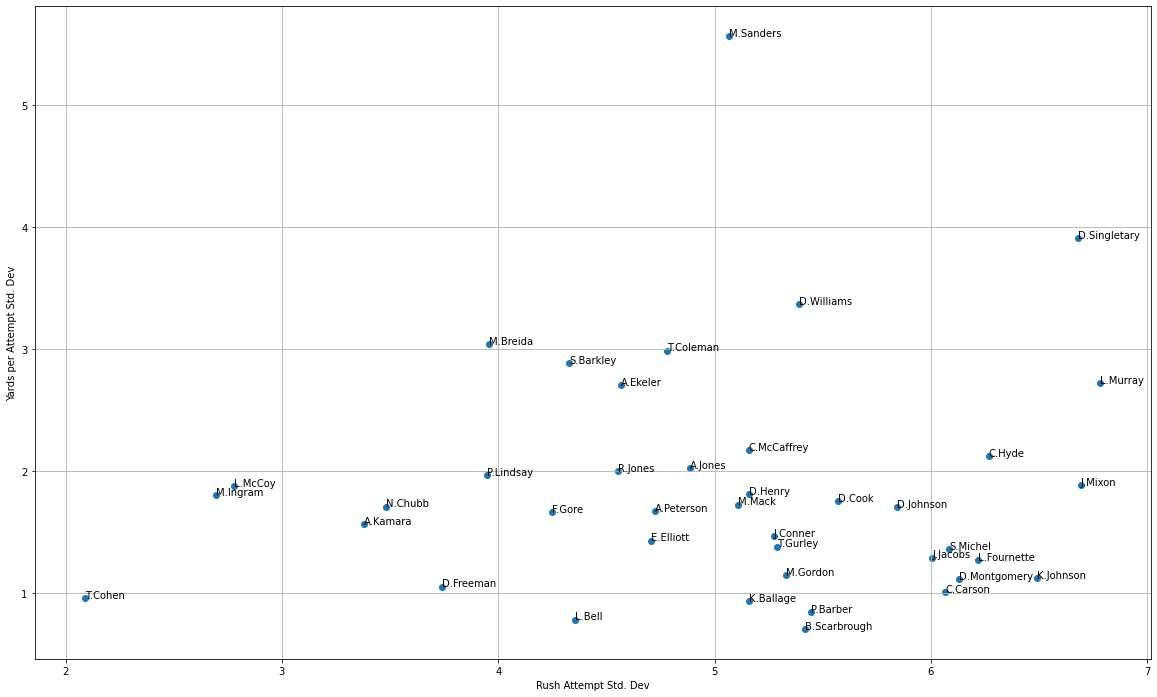

In [156]:
# Plot Tgt_Var/Rec_Var
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df['Att_Var'], con_rush_df['Y/A_Var'])
plt.xlabel('Rush Attempt Std. Dev')
plt.ylabel('Yards per Attempt Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Att_Var'][i], con_rush_df['Y/A_Var'][i]))

plt.show()

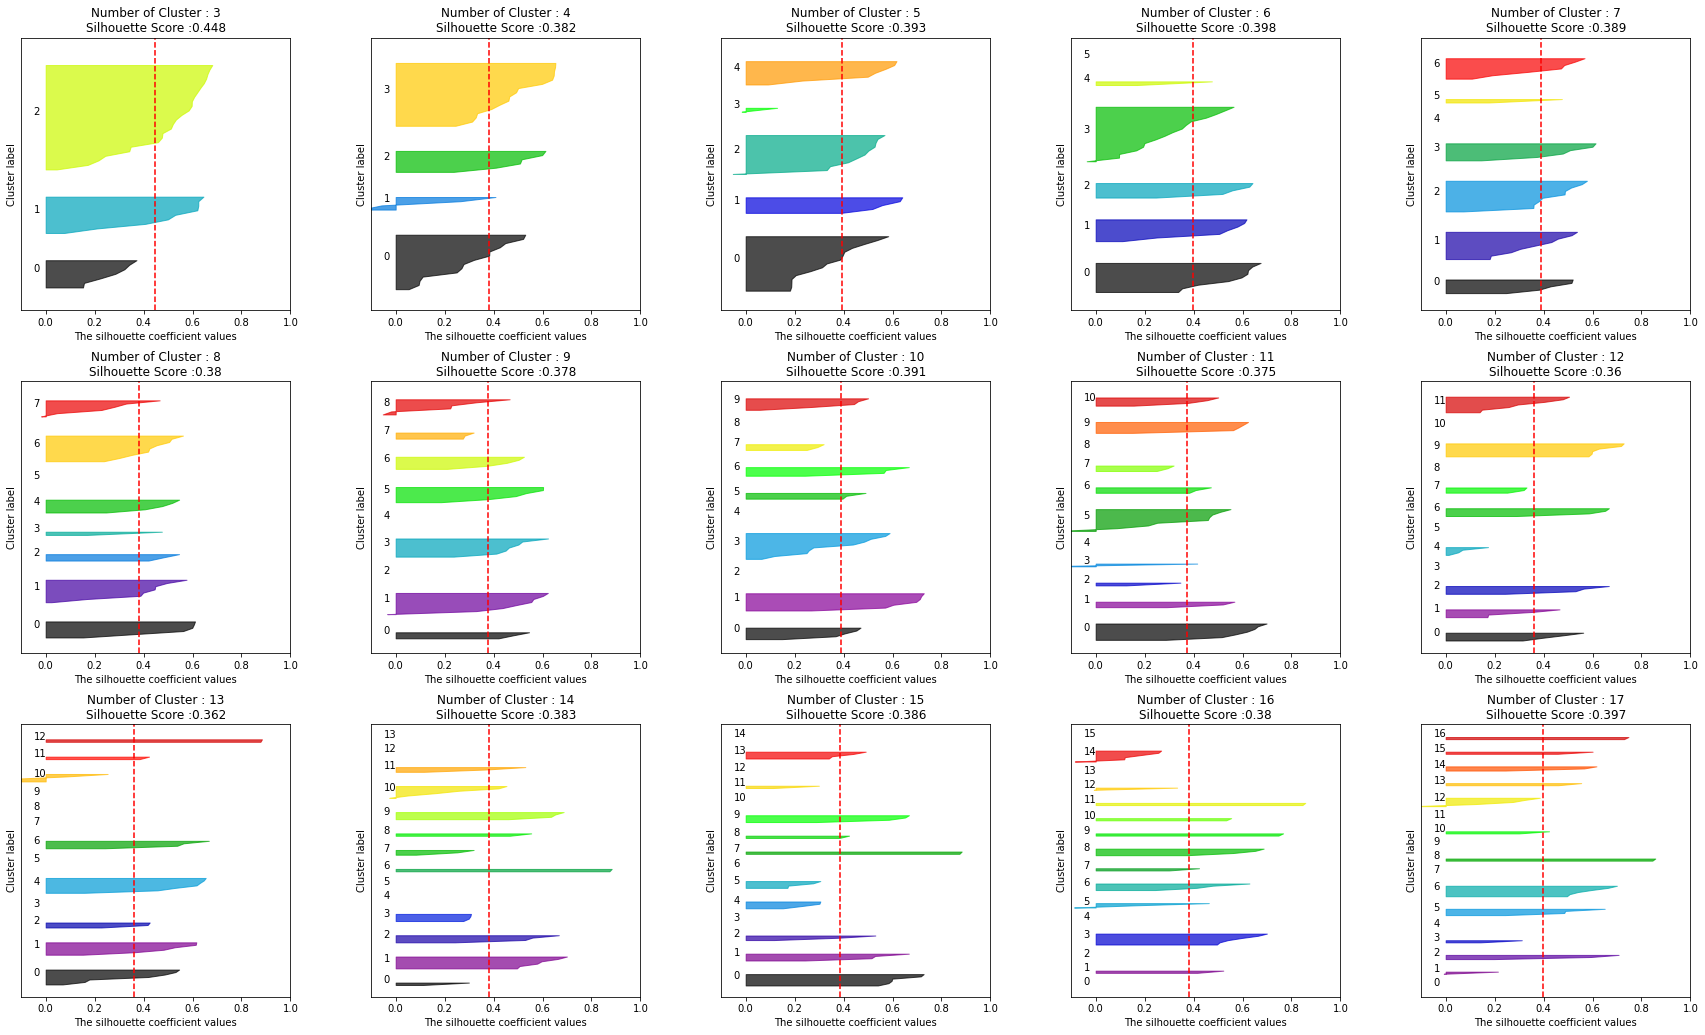

In [257]:
# Silhouette Analysis to determine optimal number of components/clusters
visualize_silhouette('KMeans', np.arange(3, 18), con_rush_df[['Att_Var','Y/A_Var']])

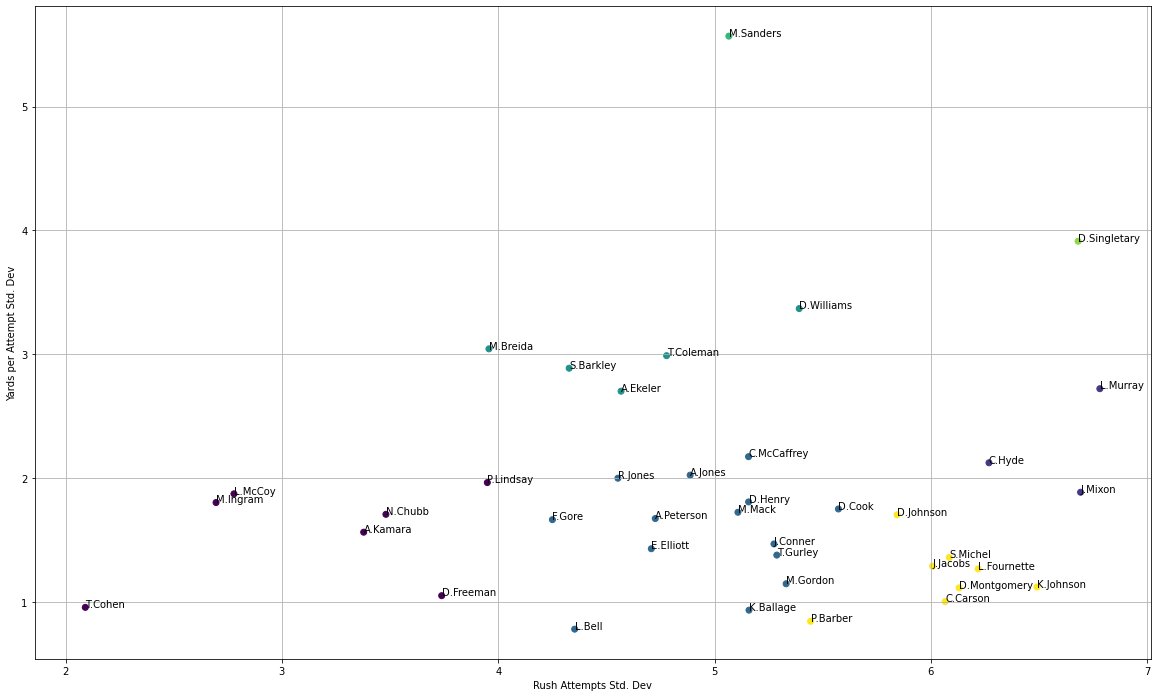

,index,Att_Var,Y/A_Var,AUC
0,0,3.158988,1.560047,4.928167
1,6,6.035723,1.212991,7.321279
2,2,4.966180,1.568533,7.789619
3,3,4.604568,2.998236,13.805584
4,1,6.580592,2.244127,14.767687
5,5,6.680478,3.912751,26.139046
6,4,5.066228,5.568535,28.211469


In [288]:
# KMeans with n_clusters=7
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7)
kmm_labels = kmeans.fit_predict(con_rush_df[['Att_Var','Y/A_Var']])
con_rush_df_name['cluster_1'] = kmm_labels

# Plot Tgt_Var/Rec_Var with Clusters
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df_name['Att_Var'], con_rush_df_name['Y/A_Var'], c=con_rush_df_name['cluster_1'])
plt.xlabel('Rush Attempts Std. Dev')
plt.ylabel('Yards per Attempt Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Att_Var'][i], con_rush_df['Y/A_Var'][i]))

plt.show()

# Cluster Centers
cc_1 = pd.DataFrame(kmeans.cluster_centers_, columns=['Att_Var','Y/A_Var'])
cc_1['AUC'] = cc_1['Att_Var'] * cc_1['Y/A_Var']
cc_1.sort_values(by='AUC', inplace=True)
cc_1.reset_index(inplace=True)
cc_1

### Target Variance vs. Yards per Target Variance

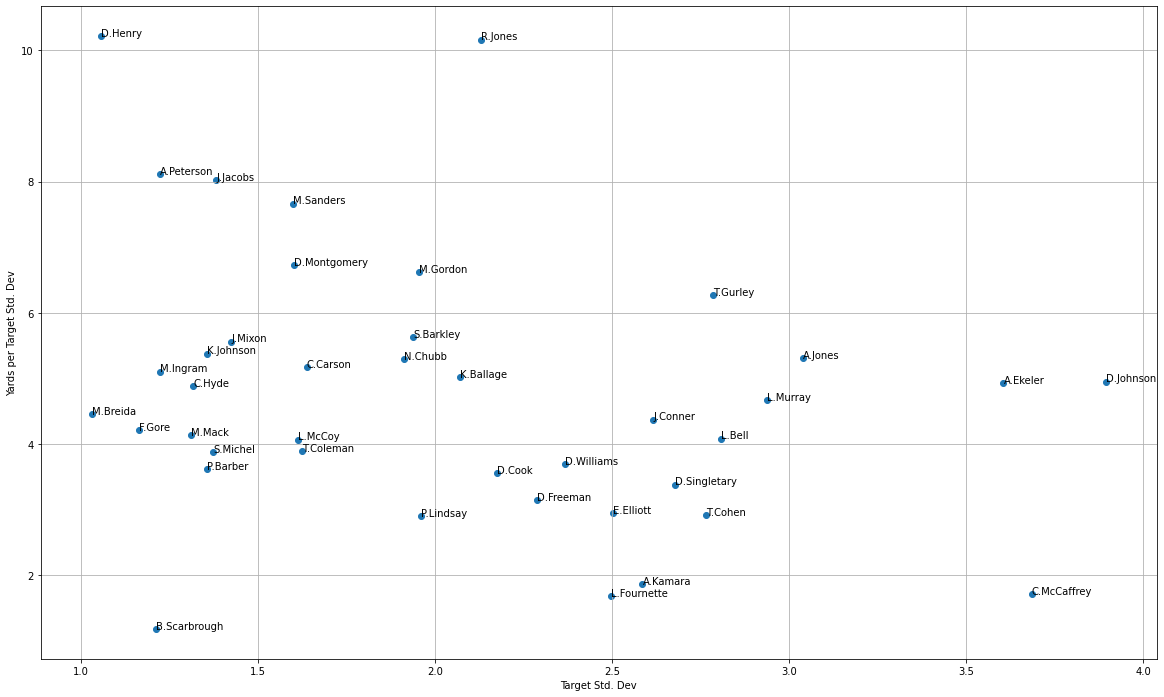

In [145]:
# Plot Tgt_Var/Y/Tgt_Var
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df['Tgt_Var'], con_rush_df['Y/Tgt_Var'])
plt.xlabel('Target Std. Dev')
plt.ylabel('Yards per Target Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Tgt_Var'][i], con_rush_df['Y/Tgt_Var'][i]))

plt.show()

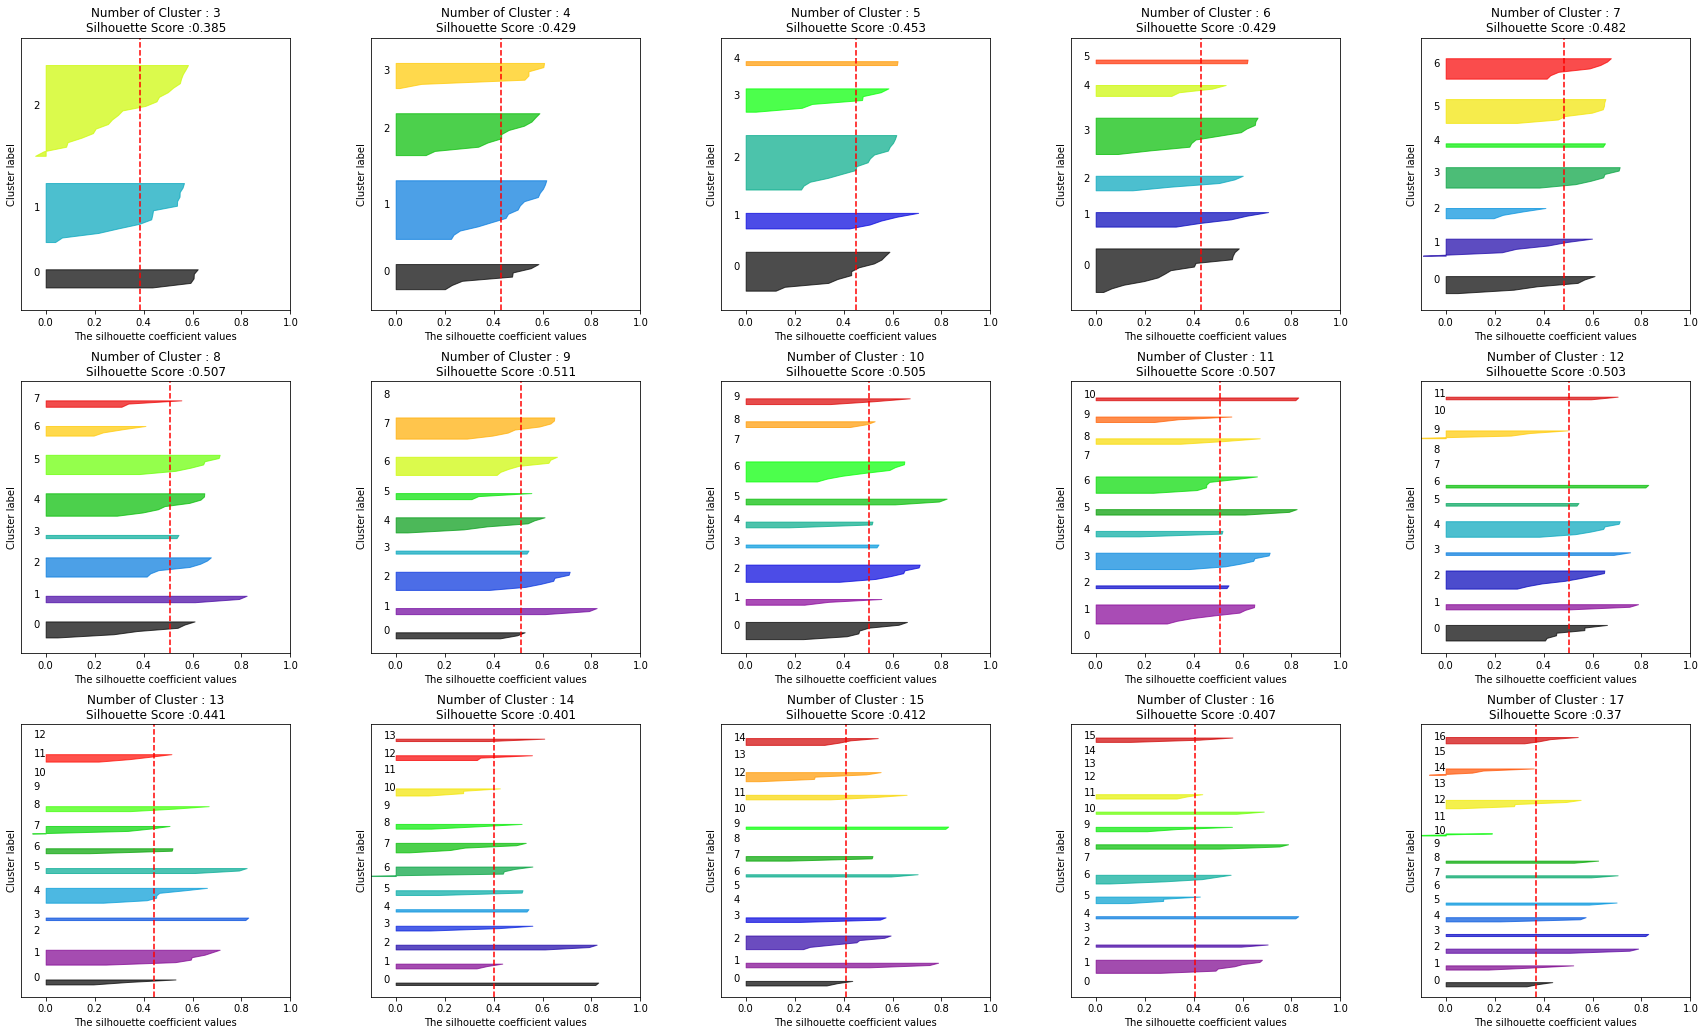

In [259]:
# Silhouette Analysis to determine optimal number of components/clusters
visualize_silhouette('KMeans', np.arange(3, 18), con_rush_df[['Tgt_Var','Y/Tgt_Var']])

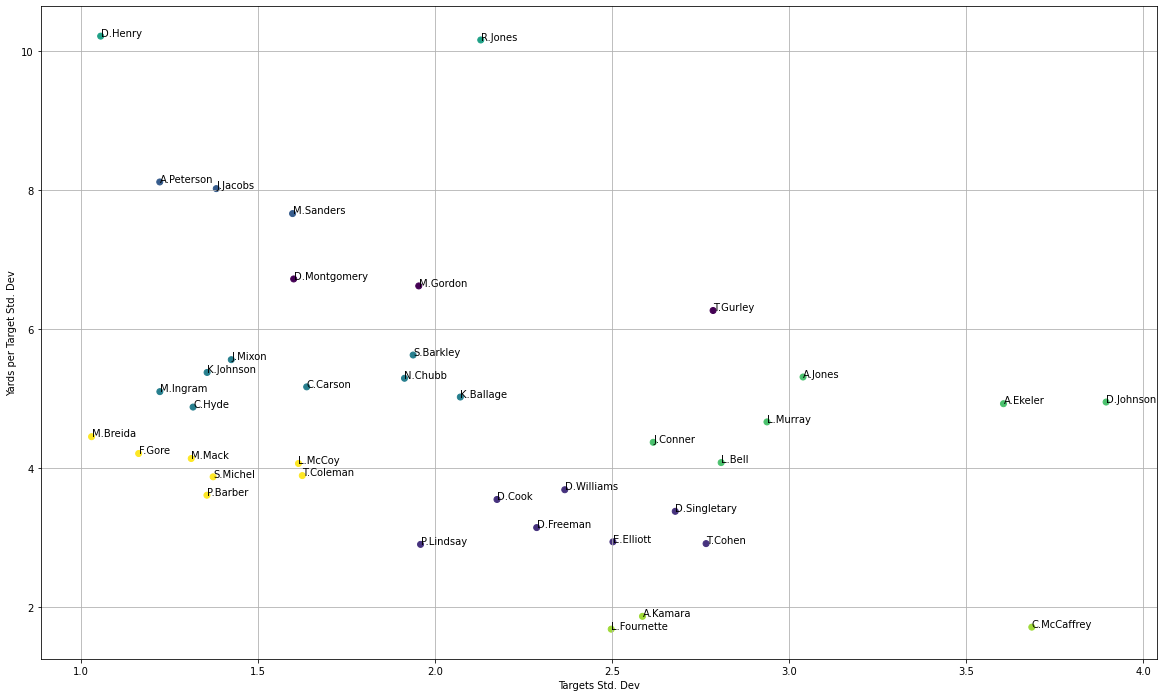

,index,Tgt_Var,Y/Tgt_Var,AUC
0,6,2.923021,1.758596,5.140413
1,7,1.353230,4.038791,5.465413
2,1,2.390600,3.220670,7.699333
3,3,1.610111,5.257064,8.464456
4,2,1.400746,7.936681,11.117272
5,0,2.113387,6.540260,13.822098
6,5,3.150379,4.720981,14.872878
7,4,1.592380,10.190425,16.227028


In [290]:
# KMeans with n_clusters=8
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8)
kmm_labels = kmeans.fit_predict(con_rush_df[['Tgt_Var','Y/Tgt_Var']])
con_rush_df_name['cluster_2'] = kmm_labels

# Plot Tgt_Var/Rec_Var with Clusters
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df_name['Tgt_Var'], con_rush_df_name['Y/Tgt_Var'], c=con_rush_df_name['cluster_2'])
plt.xlabel('Targets Std. Dev')
plt.ylabel('Yards per Target Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Tgt_Var'][i], con_rush_df['Y/Tgt_Var'][i]))

plt.show()

# Cluster Centers
cc_2 = pd.DataFrame(kmeans.cluster_centers_, columns=['Tgt_Var','Y/Tgt_Var'])
cc_2['AUC'] = cc_2['Tgt_Var'] * cc_2['Y/Tgt_Var']
cc_2.sort_values(by='AUC', inplace=True)
cc_2.reset_index(inplace=True)
cc_2

### Reception Variance vs. Yards per Reception Variance

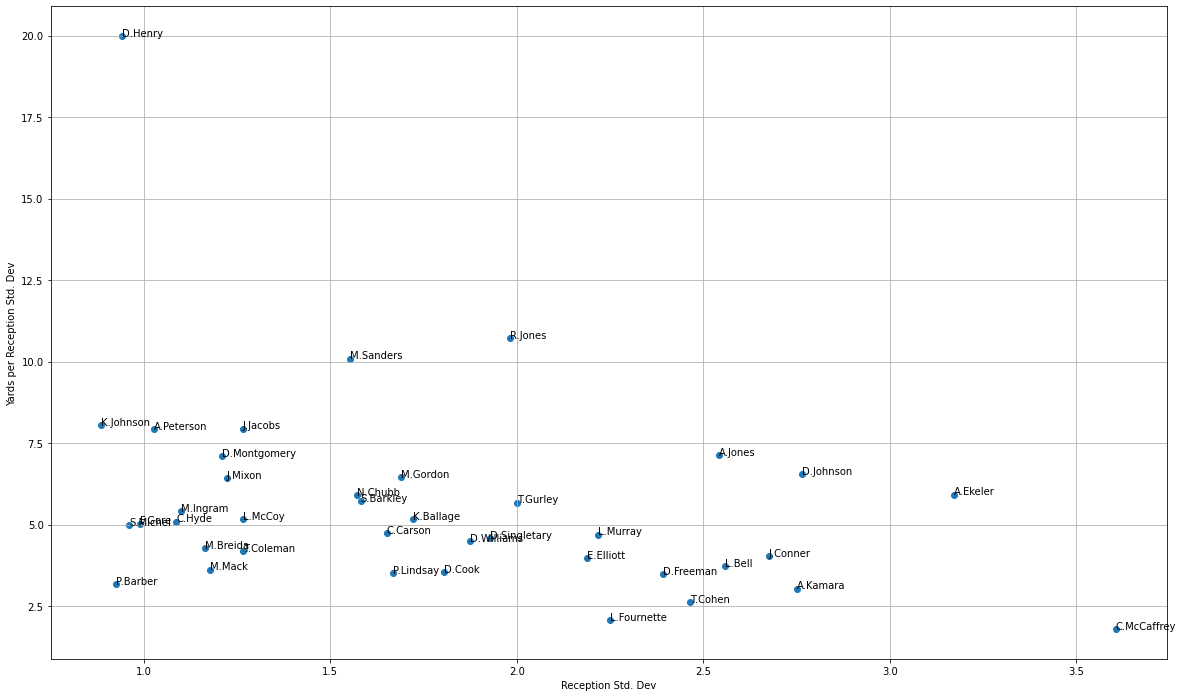

In [284]:
# Plot Rec_Var/Y/R_Var
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df['Rec_Var'], con_rush_df['Y/R_Var'])
plt.xlabel('Reception Std. Dev')
plt.ylabel('Yards per Reception Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Rec_Var'][i], con_rush_df['Y/R_Var'][i]))

plt.show()

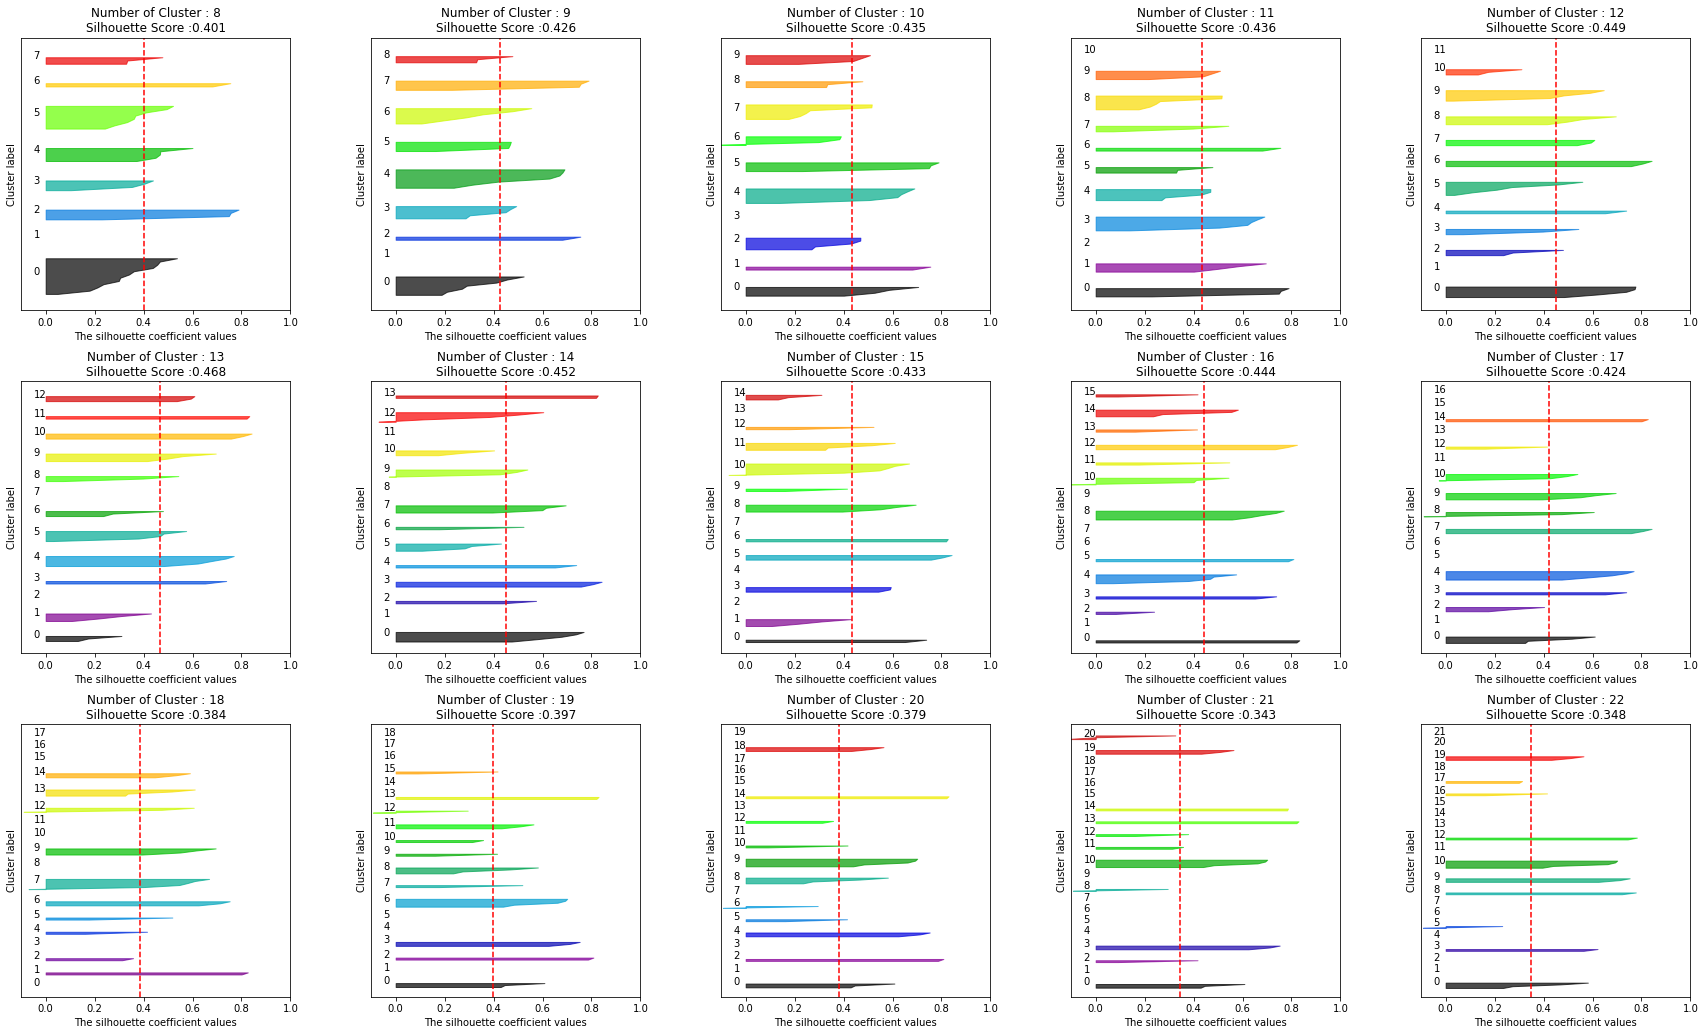

In [265]:
# Silhouette Analysis to determine optimal number of components/clusters
visualize_silhouette('KMeans', np.arange(8, 23), con_rush_df_[['Rec_Var','Y/R_Var']])

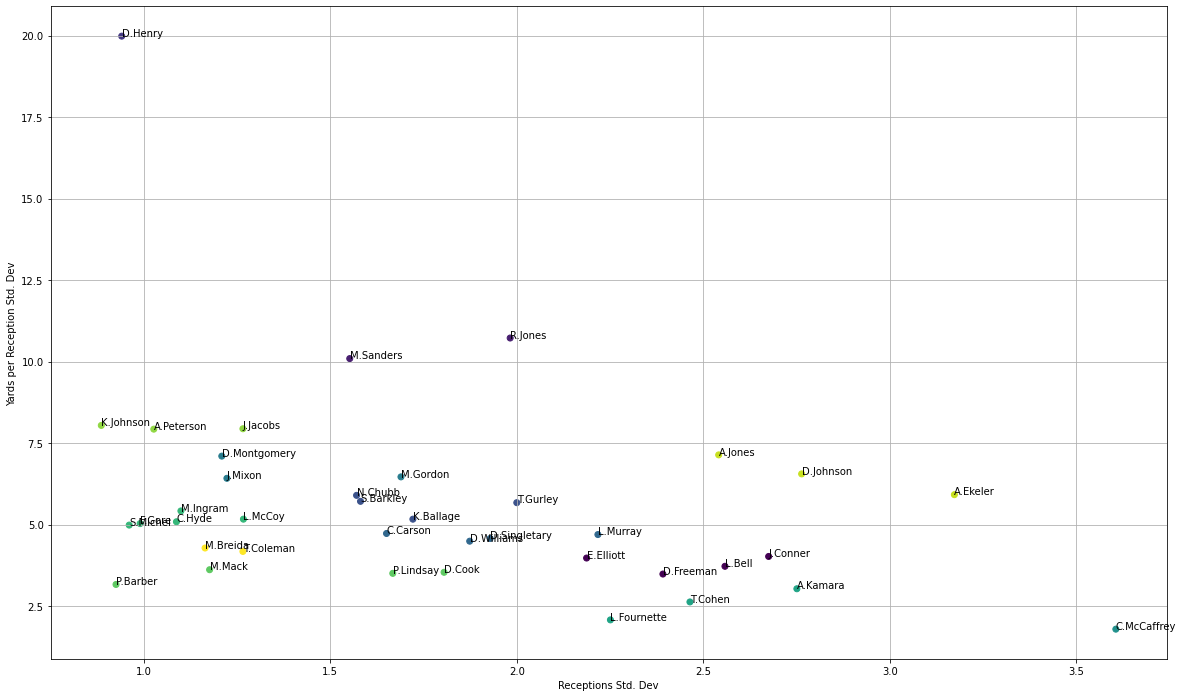

,index,Rec_Var,Y/R_Var,AUC
0,9,1.393799,3.453885,4.814021
1,12,1.215212,4.228175,5.138130
2,8,1.081296,5.136587,5.554171
3,7,2.488526,2.577389,6.413900
4,6,3.605551,1.791256,6.458466
5,10,1.059812,7.969770,8.446454
6,4,1.917661,4.621098,8.861699
7,5,1.373974,6.660800,9.151764
8,0,2.452894,3.798977,9.318488
9,3,1.718306,5.611664,9.642554


In [295]:
# KMeans with n_components=13
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

kmeans = KMeans(13)
kmeans_labels = kmeans.fit_predict(con_rush_df[['Rec_Var','Y/R_Var']])
con_rush_df_name['cluster_3'] = kmeans_labels

# Plot Tgt_Var/Rec_Var with Clusters
plt.figure(figsize=(20, 12))
plt.scatter(con_rush_df_name['Rec_Var'], con_rush_df_name['Y/R_Var'], c=con_rush_df_name['cluster_3'])
plt.xlabel('Receptions Std. Dev')
plt.ylabel('Yards per Reception Std. Dev')
plt.grid(True)
for i, name in enumerate(con_rush_df_name['Player']):
  displayName = name.split()[0][0]+'.'+name.split()[1]
  plt.annotate(displayName, (con_rush_df['Rec_Var'][i], con_rush_df['Y/R_Var'][i]))

plt.show()

# Cluster Centers
cc_3 = pd.DataFrame(kmeans.cluster_centers_, columns=['Rec_Var','Y/R_Var'])
cc_3['AUC'] = cc_3['Rec_Var'] * cc_3['Y/R_Var']
cc_3.sort_values(by='AUC', inplace=True)
cc_3.reset_index(inplace=True)
cc_3

### Consolidate clusters to identify low variance players

In [297]:
print('Att_Var vs. Y/A_Var Cluster:', '\n', cc_1)
print('\n')
print('Tgt_Var vs. Y/Tgt_Var Cluster:', '\n', cc_2)
print('\n')
print('Rec_Var vs. Y/R_Var Cluster:', '\n', cc_3)

Att_Var vs. Y/A_Var Cluster: 
    index   Att_Var   Y/A_Var        AUC
0      0  3.158988  1.560047   4.928167
1      6  6.035723  1.212991   7.321279
2      2  4.966180  1.568533   7.789619
3      3  4.604568  2.998236  13.805584
4      1  6.580592  2.244127  14.767687
5      5  6.680478  3.912751  26.139046
6      4  5.066228  5.568535  28.211469


Tgt_Var vs. Y/Tgt_Var Cluster: 
    index   Tgt_Var  Y/Tgt_Var        AUC
0      6  2.923021   1.758596   5.140413
1      7  1.353230   4.038791   5.465413
2      1  2.390600   3.220670   7.699333
3      3  1.610111   5.257064   8.464456
4      2  1.400746   7.936681  11.117272
5      0  2.113387   6.540260  13.822098
6      5  3.150379   4.720981  14.872878
7      4  1.592380  10.190425  16.227028


Rec_Var vs. Y/R_Var Cluster: 
     index   Rec_Var    Y/R_Var        AUC
0       9  1.393799   3.453885   4.814021
1      12  1.215212   4.228175   5.138130
2       8  1.081296   5.136587   5.554171
3       7  2.488526   2.577389   6.413900
4 

In [317]:
# Set Priority RBs as those in Top 3 Clusters for Rushing Attempt Variance and Target Variance
priority_rbs = con_rush_df_name[(con_rush_df_name['cluster_1'].isin([0, 6, 2])) & (con_rush_df_name['cluster_2'].isin([6, 7, 1]))]

In [320]:
# Running Backs Variance/FPG DataFrame
rb_compare_df = rush_master_df.copy()[['Player','Att/G','Att_Var','Y/A_Var','Tgt/G','Tgt_Var','Y/Tgt_Var','R/G','Rec_Var','Y/R_Var','TFP/G']]
# with pd.option_context('display.max_columns', 2000):
#   print(rush_master_df[['Att/G','Att_Var','Y/A_Var','Tgt/G','Tgt_Var','Y/Tgt_Var','TFP/G']].describe())
priority_rbs[['Player','cluster_1','cluster_2','cluster_3']].merge(rb_compare_df, how='left', on=['Player']).sort_values(by='TFP/G', ascending=False)

,Player,cluster_1,cluster_2,cluster_3,Att/G,Att_Var,Y/A_Var,Tgt/G,Tgt_Var,Y/Tgt_Var,R/G,Rec_Var,Y/R_Var,TFP/G
1,Christian McCaffrey,2,6,6,17.937500,5.157115,2.173357,8.875000,3.685557,1.716401,7.3,3.605551,1.791256,25.637500
3,Dalvin Cook,2,1,9,17.857143,5.572696,1.751055,4.500000,2.175033,3.552895,3.8,1.805060,3.535747,18.992857
0,Ezekiel Elliott,2,1,0,18.812500,4.707706,1.430128,4.437500,2.502499,2.943647,3.4,2.187083,3.973148,17.856250
2,Leonard Fournette,6,6,7,17.666667,6.218253,1.267637,6.666667,2.497618,1.687402,5.1,2.250926,2.075599,14.826667
8,Alvin Kamara,0,6,7,12.214286,3.378178,1.563727,6.928571,2.585887,1.871984,5.8,2.750624,3.030521,14.678571
4,Marlon Mack,2,7,9,17.642857,5.108171,1.724488,1.214286,1.311404,4.141994,1.0,1.176697,3.614565,12.307143
7,Devonta Freeman,0,1,0,13.142857,3.738719,1.051081,5.000000,2.287087,3.148375,4.2,2.391606,3.481966,12.078571
6,Phillip Lindsay,0,1,9,14.000000,3.949684,1.964350,3.000000,1.959106,2.906655,2.2,1.667619,3.502949,11.262500
5,Sony Michel,6,7,8,15.437500,6.085111,1.359766,1.250000,1.373213,3.878800,0.8,0.961150,4.983911,9.162500
11,LeSean McCoy,0,7,8,7.769231,2.778434,1.873319,2.615385,1.614330,4.070750,2.2,1.267304,5.165836,8.123077


Cluster 1 represents Rushing Attempt Variance in the following order: **0, 6, 2, 3, 1, 5, 4**

Cluster 2 represents Target Variance in the following order: **6, 7, 1, 3, 2, 0, 5, 4**

---

**Alvin Kamara** and **Leonard Fournette** should be our primary targets with **Phillip Lindsay** and **Marlon Mack** to round out the squad.

(*Devonta Freeman* potential)

# Clustering on Wide Receivers

## Master DataFrame

Consolidate basic receiving stats and weekly variance, plus passer rating

In [3]:
import pandas as pd
import numpy as np

# base dataframe
rec_df = pd.read_csv('Receiving.csv')
rec_df = rec_df[rec_df['Pos'].str.lower() == 'wr']
Tgt_G = rec_df['Tgt']/rec_df['G']
rec_df.insert(16, 'Tgt/G', Tgt_G)
rec_df['Player'] = rec_df['Player'].str.split('\\').str[0]
rec_df['FP/G'] = (rec_df['Rec']*0.5 + rec_df['TD']*6 + rec_df['Yds']/10)/rec_df['G']
rec_df.drop('Rk', axis=1, inplace=True)

# Player list for eligible 94 receivers
player_list = rec_df['Player'].values.tolist()

rec_df.head()

,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,Tgt/G,R/G,Y/G,Fmb,FP/G
0,Michael Thomas,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,11.562500,9.3,107.8,1,18.812500
2,Keenan Allen,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,9.312500,6.5,74.9,0,12.993750
3,DeAndre Hopkins,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,10.000000,6.9,77.7,0,14.033333
4,Julian Edelman,NWE,33,WR,16,13,153,100,65.4%,1117,11.2,6,54,44,7.3,9.562500,6.3,69.8,3,12.356250
5,Julio Jones,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,10.466667,6.6,92.9,1,14.993333


In [4]:
# 2019 Season Weekly Performance dataframe
rec_wkly_df = pd.read_csv('rec_wkly.csv')
rec_wkly_df['Player'] = rec_wkly_df['Player'].str.split('\\').str[0]
rec_wkly_df['Fantasy Points'] = rec_wkly_df['Rec']*0.5 + rec_wkly_df['TD']*6 + rec_wkly_df['Yds']/10

# Merge player games into variance/std dev stats
var_list = []
for playerName in player_list:
  player_var = rec_wkly_df[rec_wkly_df['Player']==playerName].sort_values(by='G#').reset_index(drop=True)[['Tgt','Rec','Yds','Y/R','TD','Y/Tgt','Fantasy Points']].var()
  player_var['Gms'] = rec_wkly_df[rec_wkly_df['Player']==playerName]['G#'].count()
  name_df = pd.DataFrame([playerName], columns=['Player'])
  concatenate = pd.concat([name_df.iloc[0], player_var], axis=0)
  name_var = pd.DataFrame(columns=['Player','Gms','Tgt','Rec','Yds','Y/R','TD','Y/Tgt','Fantasy Points'])
  add_player = name_var.append(concatenate, ignore_index=True)
  add_player.rename(columns={'Tgt':'Tgt_Var','Rec':'Rec_Var','Yds':'Yds_Var','Y/R':'Y/R_Var','TD':'TD_Var','Y/Tgt':'Y/Tgt_Var','Fantasy Points':'FP_Var'}, inplace=True)
  var_list.append(add_player)
variance = pd.concat(var_list)
std_dev = variance.copy()
std_dev.iloc[:, 2:] = np.sqrt(std_dev.iloc[:, 2:])
std_dev.head()

,Player,Gms,Tgt_Var,Rec_Var,Yds_Var,Y/R_Var,TD_Var,Y/Tgt_Var,FP_Var
0,Michael Thomas,16.0,2.632331,2.574717,38.793846,2.212392,0.629153,2.471039,7.496210
0,Keenan Allen,16.0,3.628016,2.780887,39.126238,3.529444,0.619139,3.010926,8.264903
0,DeAndre Hopkins,15.0,2.299068,1.791514,31.871767,4.301859,0.743223,3.261145,6.860411
0,Julian Edelman,16.0,2.988171,2.265686,31.619021,3.337391,0.619139,3.179308,6.536765
0,Julio Jones,15.0,3.440653,2.797958,39.654700,4.742980,0.736788,3.086764,7.572928


In [5]:
# Merge std_dev dataframe with base dataframe
rec_master_df = rec_df.merge(std_dev.drop('Gms', axis=1), how='left', on=['Player'])
rec_master_df.head()

,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,Tgt/G,R/G,Y/G,Fmb,FP/G,Tgt_Var,Rec_Var,Yds_Var,Y/R_Var,TD_Var,Y/Tgt_Var,FP_Var
0,Michael Thomas,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,11.562500,9.3,107.8,1,18.812500,2.632331,2.574717,38.793846,2.212392,0.629153,2.471039,7.496210
1,Keenan Allen,LAC,27,WR,16,16,149,104,69.8%,1199,11.5,6,63,45,8.0,9.312500,6.5,74.9,0,12.993750,3.628016,2.780887,39.126238,3.529444,0.619139,3.010926,8.264903
2,DeAndre Hopkins,HOU,27,WR,15,15,150,104,69.3%,1165,11.2,7,68,43,7.8,10.000000,6.9,77.7,0,14.033333,2.299068,1.791514,31.871767,4.301859,0.743223,3.261145,6.860411
3,Julian Edelman,NWE,33,WR,16,13,153,100,65.4%,1117,11.2,6,54,44,7.3,9.562500,6.3,69.8,3,12.356250,2.988171,2.265686,31.619021,3.337391,0.619139,3.179308,6.536765
4,Julio Jones,ATL,30,WR,15,15,157,99,63.1%,1394,14.1,6,77,54,8.9,10.466667,6.6,92.9,1,14.993333,3.440653,2.797958,39.654700,4.742980,0.736788,3.086764,7.572928


## Performance-based Clustering

We have selected the following 4 features to form clusters on players' overall performance last season.

- **R/G** : Receptions per Game
- **Y/G** : Yards per Game
- **TD** : Total TouchDowns
- **FP/G** : Fantasy Points per Game

In [6]:
# Extract aforementioned features
perf_df_name = rec_master_df.copy()[['Player','R/G', 'Y/G', 'TD', 'FP/G']]
perf_df = perf_df_name.drop('Player', axis=1)
perf_df.describe()

,R/G,Y/G,TD,FP/G
count,94.000000,94.000000,94.000000,94.000000
mean,3.594681,47.961702,4.319149,8.452929
std,1.731825,23.481913,2.611854,3.950247
min,0.300000,1.900000,0.000000,0.661538
25%,2.125000,28.650000,2.000000,5.114062
50%,3.500000,48.550000,4.000000,8.500000
75%,4.775000,66.475000,6.000000,11.643019
max,9.300000,107.800000,11.000000,18.812500


### Peform PCA to determine optimal number of components

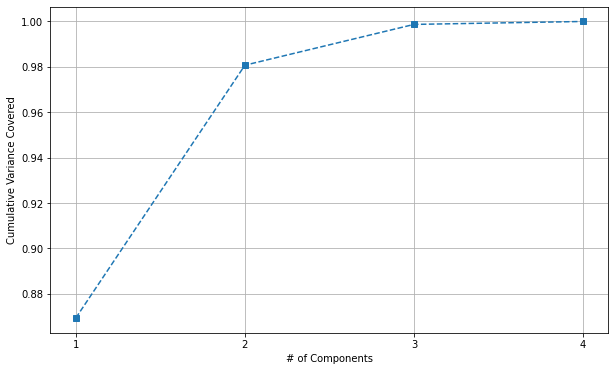

Total variance explained at n_components=2: 0.9807
Total variance explained at n_components=3: 0.9987


In [7]:
# PCA for Dimension Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
pca = PCA()

# Scale rushing stats before PCA
scaler.fit(perf_df)
perf_scaled = scaler.transform(perf_df)

pca.fit(perf_scaled)
x_val = list(range(1, len(pca.explained_variance_ratio_)+1))

plt.figure(figsize=(10, 6))
plt.plot(x_val, np.cumsum(pca.explained_variance_ratio_), '--s')
plt.xticks(np.arange(min(x_val), max(x_val)+1, 1.0))
plt.xlabel('# of Components')
plt.ylabel('Cumulative Variance Covered')
plt.grid(True)
plt.show()

print('Total variance explained at n_components=2: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:2])))
print('Total variance explained at n_components=3: {:.4f}'.format(np.sum(pca.explained_variance_ratio_[:3])))

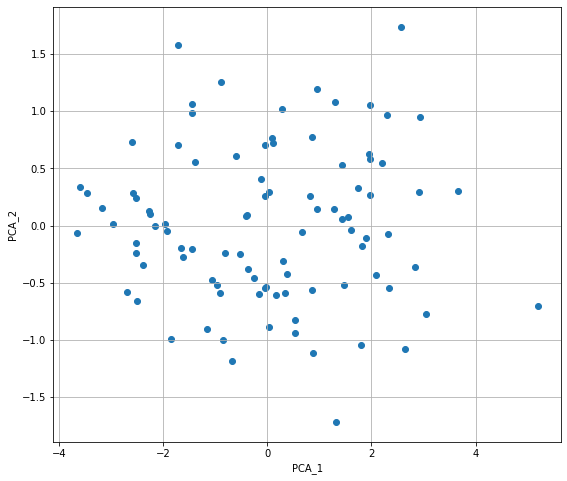

In [8]:
# PCA Plots
perf_pca_2 = PCA(n_components=2).fit_transform(perf_scaled)
perf_pca_2_df = pd.DataFrame(perf_pca_2, columns=['PCA_1', 'PCA_2'])

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(perf_pca_2_df['PCA_1'], perf_pca_2_df['PCA_2'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

plt.show()

### K-Means Clustering - Determine the ideal number of clusters with Silhouette Analysis

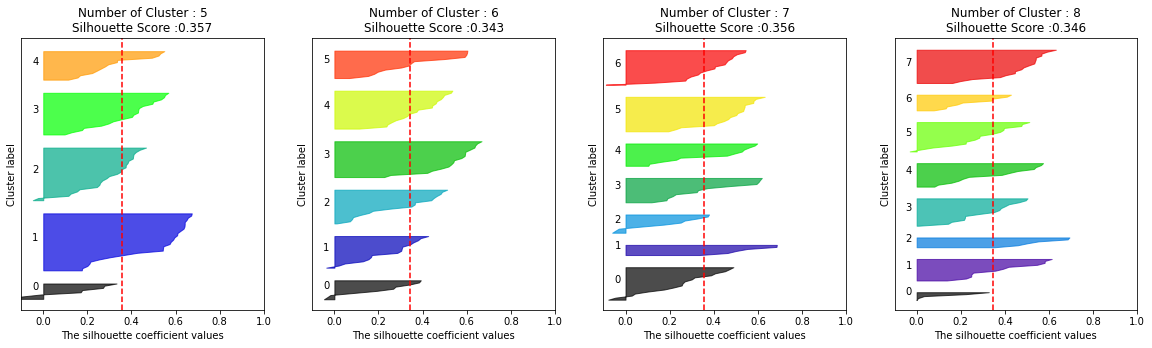

In [9]:
# Silhouette Visualization fucntion
def visualize_silhouette(cluster_list, X_features):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_samples, silhouette_score
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  # Number of Silhouette Scores to plot
  n_cols = len(cluster_list)
  fig, axs = plt.subplots(figsize=(5*n_cols, 5), nrows=1, ncols=n_cols)
  
  # iterate through the n_clusters list and visualize for each selection
  for ind, n_cluster in enumerate(cluster_list):
    clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
    cluster_labels = clusterer.fit_predict(X_features)
    sil_avg = silhouette_score(X_features, cluster_labels)
    sil_values = silhouette_samples(X_features, cluster_labels)
    y_lower = 5
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' 'Silhouette Score :' + str(round(sil_avg,3)))
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(X_features) + ((n_cluster + 1) * 5)])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # plot using fill_betweenx() for each cluster
    for i in range(n_cluster):
      ith_cluster_sil_values = sil_values[cluster_labels==i]
      ith_cluster_sil_values.sort()
      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i
      color = cm.nipy_spectral(float(i) / n_cluster)
      axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
      axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 5
    axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
  
visualize_silhouette([5, 6, 7, 8], perf_scaled)

In [10]:
# Find cluster centers
from sklearn.cluster import KMeans

kmeans_perf = KMeans(n_clusters=4, max_iter=500)
kmeans_perf.fit(perf_scaled)
cluster_avg = pd.DataFrame(scaler.inverse_transform(kmeans_perf.cluster_centers_), columns=perf_df.columns)
cluster_avg

,R/G,Y/G,TD,FP/G
0,4.477273,65.290909,7.136364,11.689491
1,1.567857,19.335714,2.142857,3.668573
2,6.509091,83.000000,7.000000,14.382582
3,3.754545,49.018182,3.393939,8.378124


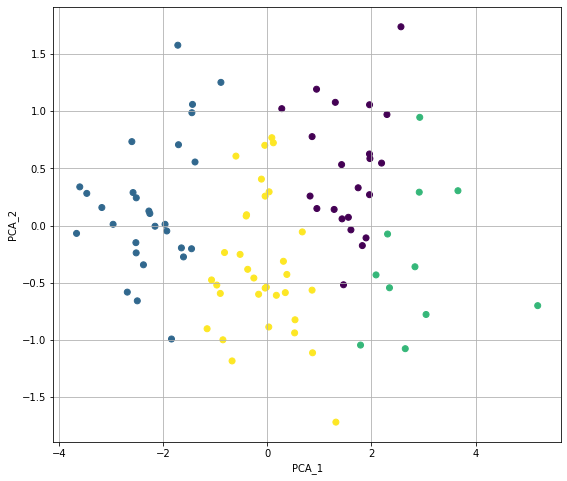

In [11]:
# PCA Plots with labels
perf_pca_2_df['label'] = kmeans_perf.labels_

fig = plt.figure(figsize=(20, 8))

# n_components=2
ax = fig.add_subplot(1, 2, 1)
ax.scatter(perf_pca_2_df['PCA_1'], perf_pca_2_df['PCA_2'], c=perf_pca_2_df['label'])
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.grid(True)

plt.show()

In [12]:
perf_df_labeled = perf_df_name.copy()
perf_df_labeled['cluster'] = kmeans_perf.labels_

In [13]:
print(perf_df_labeled[perf_df_labeled['cluster'] == 1])
print('\n')
print(perf_df_labeled[perf_df_labeled['cluster'] == 3])

                      Player  R/G   Y/G  TD      FP/G  cluster
53             Alex Erickson  2.7  33.1   0  4.650000        1
63          Geronimo Allison  2.1  17.9   2  3.606250        1
64               Allen Hurns  2.3  29.7   2  4.971429        1
65         Demarcus Robinson  2.0  28.1   4  5.306250        1
67              Willie Snead  1.9  21.2   5  4.962500        1
68              Ted Ginn Jr.  1.9  26.3   2  4.318750        1
69             Kelvin Harmon  1.9  22.8   0  3.218750        1
72           Paul Richardson  2.8  24.5   2  5.050000        1
74             Jarius Wright  1.8  18.5   0  2.725000        1
75           Isaiah McKenzie  1.8  16.9   1  2.993333        1
76            Mecole Hardman  1.6  33.6   6  6.425000        1
77                Trey Quinn  2.2  16.5   1  3.233333        1
78  Marquez Valdes-Scantling  1.6  28.3   2  4.387500        1
79              Tajae Sharpe  1.7  21.9   4  4.626667        1
80              Cody Latimer  1.6  20.0   2  3.600000  

### DBSCAN Clustering

## Consistency-based Clustering

We have selected the following 3 features to form clusters on players' consistency (weekly) last season.

- **Tgt_Var** : Target Variance(Std.Dev)
- **Rec_Var** : Reception Variance(Std.Dev)
- **Y/R_Var** : Yards per Reception Variance(Std.Dev)

In [14]:
# Extract aforementioned features
con_df_name = rec_master_df.copy()[['Player','Tgt_Var', 'Rec_Var']]
con_df_name.info()
print('\n')
print('-'*100)

# Drop 3 players with info unavailable : Taysom Hill, Daniel Brown, Lee Smith
con_df_name.dropna(axis=0, inplace=True)
con_df = con_df_name.drop('Player', axis=1)
con_df.info()
print(con_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   94 non-null     object 
 1   Tgt_Var  91 non-null     float64
 2   Rec_Var  91 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.9+ KB


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 92
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tgt_Var  91 non-null     float64
 1   Rec_Var  91 non-null     float64
dtypes: float64(2)
memory usage: 2.1 KB
         Tgt_Var    Rec_Var
count  91.000000  91.000000
mean    2.688091   2.001577
std     0.904768   0.682124
min     0.834847   0.621582
25%     2.025634   1.473547
50%     2.620433   1.962142
75%     3.257497   2.424650
max     4.821161   3.792537


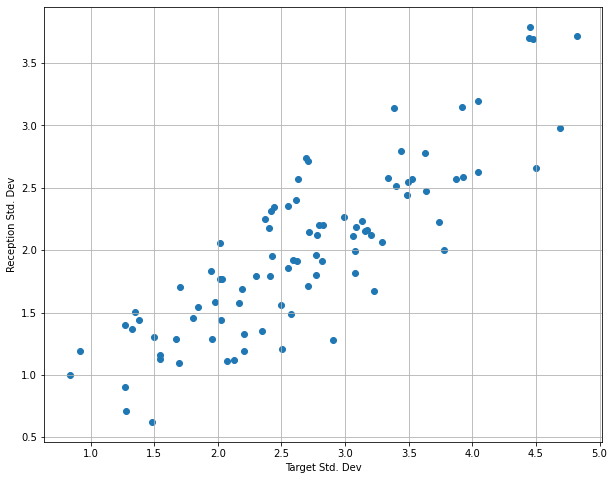

In [15]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Plot Tgt_Var/Rec_Var
plt.figure(figsize=(10, 8))
plt.scatter(con_df['Tgt_Var'], con_df['Rec_Var'])
plt.xlabel('Target Std. Dev')
plt.ylabel('Reception Std. Dev')
plt.grid(True)

plt.show()

### Silhouette Analysis to determine n_components for Gaussian Mixture Model

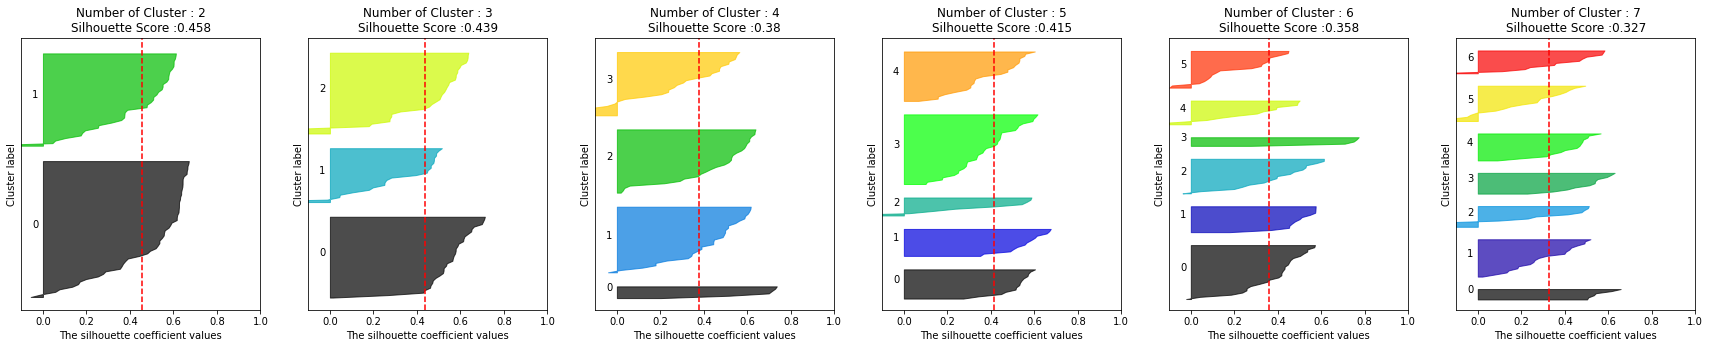

In [16]:
# Silhouette Visualization fucntion
def visualize_silhouette(cluster_list, X_features):
  from sklearn.mixture import GaussianMixture
  from sklearn.metrics import silhouette_samples, silhouette_score
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  # Number of Silhouette Scores to plot
  n_cols = len(cluster_list)
  fig, axs = plt.subplots(figsize=(5*n_cols, 5), nrows=1, ncols=n_cols)
  
  # iterate through the n_clusters list and visualize for each selection
  for ind, n_cluster in enumerate(cluster_list):
    clusterer = GaussianMixture(n_components=n_cluster)
    cluster_labels = clusterer.fit_predict(X_features)
    sil_avg = silhouette_score(X_features, cluster_labels)
    sil_values = silhouette_samples(X_features, cluster_labels)
    y_lower = 5
    axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' 'Silhouette Score :' + str(round(sil_avg,3)))
    axs[ind].set_xlabel("The silhouette coefficient values")
    axs[ind].set_ylabel("Cluster label")
    axs[ind].set_xlim([-0.1, 1])
    axs[ind].set_ylim([0, len(X_features) + ((n_cluster + 1) * 5)])
    axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
    axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # plot using fill_betweenx() for each cluster
    for i in range(n_cluster):
      ith_cluster_sil_values = sil_values[cluster_labels==i]
      ith_cluster_sil_values.sort()
      size_cluster_i = ith_cluster_sil_values.shape[0]
      y_upper = y_lower + size_cluster_i
      color = cm.nipy_spectral(float(i) / n_cluster)
      axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
      axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      y_lower = y_upper + 5
    axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
  
visualize_silhouette(np.arange(2, 8), con_df)

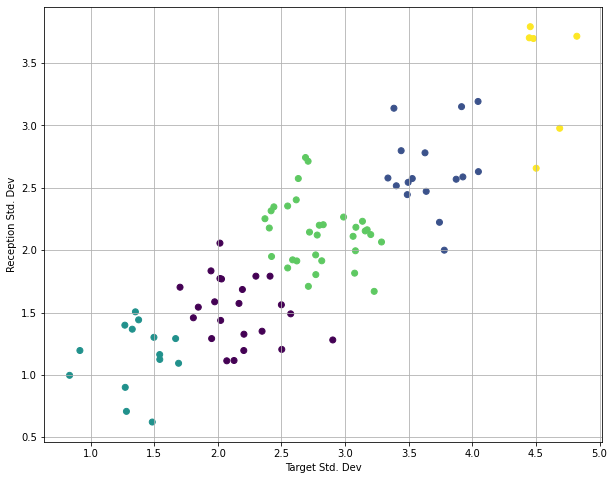

In [ ]:
from sklearn.mixture import GaussianMixture

# Cluster using Gaussian Mixture Model
gmm = GaussianMixture(5)
gmm_labels = gmm.fit_predict(con_df)
con_df_name['cluster'] = gmm_labels

# Plot Tgt_Var/Rec_Var with Clusters
plt.figure(figsize=(10, 8))
plt.scatter(con_df_name['Tgt_Var'], con_df_name['Rec_Var'], c=con_df_name['cluster'])
plt.xlabel('Target Std. Dev')
plt.ylabel('Reception Std. Dev')
plt.grid(True)

plt.show()

In [23]:
# Cluster Centers
pd.DataFrame(gmm.means_, columns=['Target Std Dev', 'Reception Std Dev'])

,Target Std Dev,Reception Std Dev
0,2.171883,1.528687
1,3.641809,2.609136
2,1.384820,1.167156
3,2.795367,2.137118
4,4.565438,3.428063


In [52]:
# Players in Cluster 2 (Lowest Variance)
cluster_names = con_df_name[con_df_name['cluster']==3]['Player'].values.tolist()
con_df_name[con_df_name['cluster']==3]

,Player,Tgt_Var,Rec_Var,cluster
0,Michael Thomas,2.632331,2.574717,3
3,Julian Edelman,2.988171,2.265686,3
5,Allen Robinson,3.201562,2.125245,3
10,Chris Godwin,2.709365,2.713418,3
12,Jarvis Landry,2.418677,2.315707,3
16,Larry Fitzgerald,2.587631,1.922455,3
17,Odell Beckham Jr.,2.548692,1.857418,3
18,DJ Chark,3.136574,2.231805,3
19,John Brown,3.062834,2.111195,3
20,DeVante Parker,3.286335,2.065591,3


In [53]:
rec_df[rec_df['Player'].isin(cluster_names)]

,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,1D,Lng,Y/Tgt,Tgt/G,R/G,Y/G,Fmb,FP/G
0,Michael Thomas,NOR,26,WR,16,15,185,149,80.5%,1725,11.6,9,91,49,9.3,11.562500,9.3,107.8,1,18.812500
4,Julian Edelman,NWE,33,WR,16,13,153,100,65.4%,1117,11.2,6,54,44,7.3,9.562500,6.3,69.8,3,12.356250
6,Allen Robinson,CHI,26,WR,16,15,154,98,63.6%,1147,11.7,7,63,49,7.4,9.625000,6.1,71.7,0,12.856250
15,Chris Godwin,TAM,23,WR,14,14,121,86,71.1%,1333,15.5,9,63,71,11.0,8.642857,6.1,95.2,0,16.450000
18,Jarvis Landry,CLE,27,WR,16,16,138,83,60.1%,1174,14.1,6,55,65,8.5,8.625000,5.2,73.4,0,12.181250
25,Larry Fitzgerald,ARI,36,WR,16,16,109,75,68.8%,804,10.7,4,40,54,7.4,6.812500,4.7,50.3,1,8.868750
27,Odell Beckham Jr.,CLE,27,WR,16,15,133,74,55.6%,1035,14.0,4,44,89,7.8,8.312500,4.6,64.7,1,10.281250
28,DJ Chark,JAX,23,WR,15,14,118,73,61.9%,1008,13.8,8,42,69,8.5,7.866667,4.9,67.2,0,12.353333
29,John Brown,BUF,29,WR,15,15,115,72,62.6%,1060,14.7,6,53,53,9.2,7.666667,4.8,70.7,0,11.866667
30,DeVante Parker,MIA,26,WR,16,14,128,72,56.3%,1202,16.7,9,58,51,9.4,8.000000,4.5,75.1,0,13.137500


In [42]:
rec_master_df.iloc[:, 10:].describe()

,Y/R,TD,1D,Lng,Y/Tgt,Tgt/G,R/G,Y/G,Fmb,FP/G,Tgt_Var,Rec_Var,Yds_Var,Y/R_Var,TD_Var,Y/Tgt_Var,FP_Var
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,13.315957,4.319149,32.659574,49.946809,8.154255,5.787508,3.594681,47.961702,0.702128,8.452929,2.688091,2.001577,33.197729,6.424306,0.550739,5.156371,6.340702
std,2.727530,2.611854,17.971036,17.011929,1.713555,2.527380,1.731825,23.481913,1.065891,3.950247,0.904768,0.682124,11.511496,3.059203,0.218578,2.408709,2.272491
min,7.600000,0.000000,2.000000,9.000000,3.300000,0.312500,0.300000,1.900000,0.000000,0.661538,0.834847,0.621582,9.018500,1.414214,0.000000,2.230951,1.347484
25%,11.500000,2.000000,18.000000,38.250000,7.225000,3.697917,2.125000,28.650000,0.000000,5.114062,2.025634,1.473547,24.962698,4.390986,0.414039,3.542278,4.977573
50%,13.150000,4.000000,31.000000,47.500000,8.150000,6.000000,3.500000,48.550000,0.000000,8.500000,2.620433,1.962142,32.874654,5.810165,0.593617,4.561218,6.216011
75%,15.075000,6.000000,42.750000,58.750000,9.200000,7.593750,4.775000,66.475000,1.000000,11.643019,3.257497,2.424650,40.354036,7.804534,0.701680,5.945556,7.685800
max,20.700000,11.000000,91.000000,92.000000,13.100000,11.562500,9.300000,107.800000,5.000000,18.812500,4.821161,3.792537,64.225314,19.012991,1.182132,19.006177,13.025388
